In [1]:
import tools
import copy
import numpy
from IPython.display import Image # For GIFs

In [2]:
liq = 0
sol = 1

In [3]:
size = 100
n_steps = 100
state = [liq] * size
state[50] = sol

In [4]:
tools.display_state(state)

In [5]:
prev_states = []
temp_state = copy.deepcopy(state)
prev_states.append(state)
for dt in range(size):
    for cell in range(size):
        if sum(state[cell-1:cell+2]) > 0:
            temp_state[cell] = sol
    state = copy.deepcopy(temp_state)
    prev_states.append(state)

In [6]:
def simulate_growth(size):
    state = [liq] * size
    state = [liq] * size
    state[size//2] = sol
    state[size//10+1] = sol
    temp_state = copy.deepcopy(state)
    prev_states = [state]
    for dt in range(size):
        for cell in range(size):
            if cell == 0:
                if state[cell+1] == sol:
                    temp_state[cell] = sol
            elif cell == size-1:
                if state[cell-1] == sol:
                    temp_state[cell] = sol
            elif state[cell-1] == sol or state[cell+1] == sol:
                temp_state[cell] = sol
        state = copy.deepcopy(temp_state)
        prev_states.append(state)
    return prev_states

In [7]:
prev_states = simulate_growth(100)
# tools.display_growth(prev_states, show_fraction=True)

In [8]:
tools.animate_growth(prev_states)
# Image(url='test_anim.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


In [9]:
def simulate_growth_2D(size):

    state = numpy.zeros((size, size))
    state = tools.set_nucleation_sites(state, 100)
    # Copy state to keep track of history
    temp_state = copy.deepcopy(state)
    prev_states = []
    # Loop over each cell
    while numpy.sum(state) < size*size:
        for x in range(size):
            for y in range(size):
                if state[y,x] == sol:
                        temp_state[y-1:y+2, x-1:x+2] = sol

        state = copy.deepcopy(temp_state)
        prev_states.append(copy.deepcopy(temp_state))
    return prev_states

In [10]:
prev_states = simulate_growth_2D(100)

MovieWriter ffmpeg unavailable; using Pillow instead.


17


IndexError: list index out of range

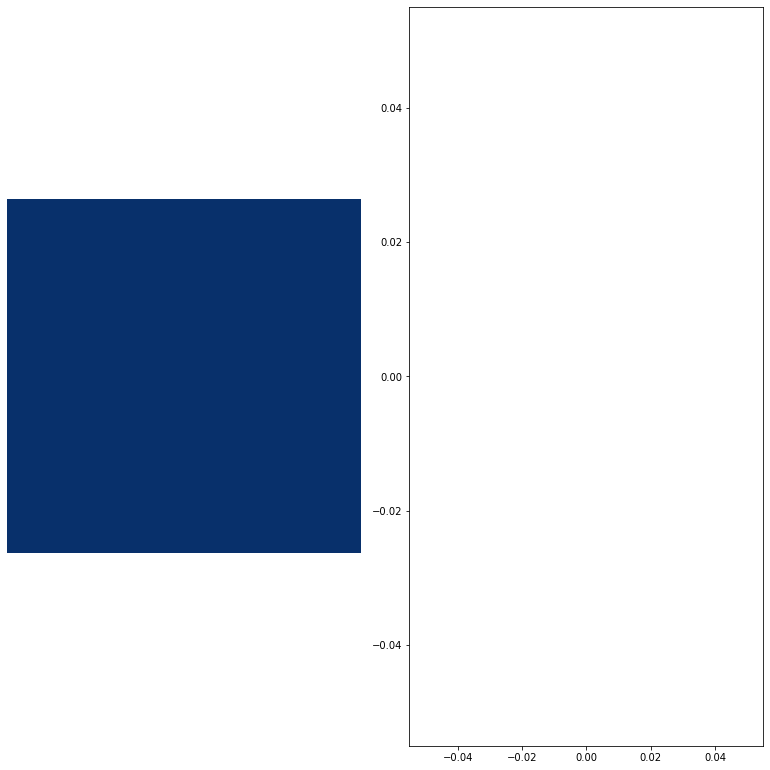

In [11]:
tools.animate_growth_2D(prev_states)
Image(url='test_anim_2D.gif')
len(prev_states)